In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import json
import os
import time
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
data_dir = "C:/Users/mhoyl/STAT480/FinalProject/sofia_sensors"

In [3]:
analysis_files = [file for file in os.listdir(data_dir) if file.endswith("_sds011sof.csv")][12:]
analysis_files

['2018-07_sds011sof.csv',
 '2018-08_sds011sof.csv',
 '2018-09_sds011sof.csv',
 '2018-10_sds011sof.csv',
 '2018-11_sds011sof.csv',
 '2018-12_sds011sof.csv',
 '2019-01_sds011sof.csv',
 '2019-02_sds011sof.csv',
 '2019-03_sds011sof.csv',
 '2019-04_sds011sof.csv',
 '2019-05_sds011sof.csv',
 '2019-06_sds011sof.csv']

In [4]:
start_time = time.time()

sofia_dfs = []
for file in analysis_files:
    sofia_dfs.append(pd.read_csv(f"{data_dir}/{file}").drop("Unnamed: 0", axis = 1))
    
print(round((time.time() - start_time)/60, 3), " min")

0.808  min


In [5]:
sofia_dataset = pd.concat(sofia_dfs, axis = 0)

In [6]:
del sofia_dfs

In [7]:
sofia_dataset.drop(["location", "timestamp", "P1", "P2"], axis = 1)

,sensor_id,lat,lon
0,1020,42.647,23.270
1,11560,42.677,23.264
2,11098,42.650,23.364
3,1953,42.704,23.354
4,3511,42.683,23.335
...,...,...,...
5904994,22646,42.726,23.268
5904995,6731,42.674,23.256
5904996,23163,42.692,23.362
5904997,2039,42.686,23.350


In [10]:
sensor_latlong = sofia_dataset.drop('location', axis = 1).groupby(['sensor_id']).mean().reset_index()
sensor_latlong

,sensor_id,lat,lon,P1,P2
0,739,42.694000,23.336797,32.206237,19.305911
1,753,42.626000,23.378000,14.403819,8.782270
2,787,42.708000,23.312000,29.851799,22.330355
3,797,42.704895,23.312000,28.203873,21.211045
4,1018,42.643000,23.409000,38.507151,18.132741
...,...,...,...,...,...
448,27059,42.669431,23.233351,19.800068,11.360315
449,27209,42.668000,23.386000,11.967815,6.702985
450,27957,42.658000,23.374000,16.245968,11.039703
451,28130,42.634000,23.374000,16.063892,9.246601


In [27]:
sensor_latlong.to_csv("sensors_latlong.csv")

In [17]:
with open("Sofia_GeoMapping.json", 'r') as j:
     SofiaGeoMap = json.loads(j.read())

In [18]:
test_data = sensor_latlong.copy()
test_data.copy()

,sensor_id,lat,lon,P1,P2
0,739,42.694000,23.336797,32.206237,19.305911
1,753,42.626000,23.378000,14.403819,8.782270
2,787,42.708000,23.312000,29.851799,22.330355
3,797,42.704895,23.312000,28.203873,21.211045
4,1018,42.643000,23.409000,38.507151,18.132741
...,...,...,...,...,...
448,27059,42.669431,23.233351,19.800068,11.360315
449,27209,42.668000,23.386000,11.967815,6.702985
450,27957,42.658000,23.374000,16.245968,11.039703
451,28130,42.634000,23.374000,16.063892,9.246601


In [25]:
sensor_districts = {}
district_names = []
for i in range(test_data.shape[0]):
    
    point_coords = (float(sensor_latlong[sensor_latlong['sensor_id'] == test_data['sensor_id'][i]]['lon']), 
                    float(sensor_latlong[sensor_latlong['sensor_id'] == test_data['sensor_id'][i]]['lat'])) # Vitosha
    
    districts_ = []
    
    for district in SofiaGeoMap['features']:
        district_name = district['id']
        district_names.append(district_name)
        poly_object = Polygon(district['geometry']['coordinates'][0])
        bool_dist = poly_object.contains(Point(point_coords))
        
        if bool_dist:
            districts_.append(district_name)
            
    sensor_districts[str(test_data['sensor_id'][i])] = districts_
    
    district_names = list(set(district_names))

In [27]:
with open("SofiaSensorDistricts.json", "w") as outfile:
    json.dump(sensor_districts, outfile)

In [32]:
test_data['district'] = test_data['sensor_id'].astype(str)

In [33]:
test_data['district'] = test_data['district'].replace(sensor_districts)

In [34]:
test_data

,sensor_id,lat,lon,P1,P2,district
0,739,42.694000,23.336797,32.206237,19.305911,Sredets
1,753,42.626000,23.378000,14.403819,8.782270,Mladost
2,787,42.708000,23.312000,29.851799,22.330355,Serdika
3,797,42.704895,23.312000,28.203873,21.211045,Vazrazhdane
4,1018,42.643000,23.409000,38.507151,18.132741,Iskar
...,...,...,...,...,...,...
448,27059,42.669431,23.233351,19.800068,11.360315,Ovcha kupel
449,27209,42.668000,23.386000,11.967815,6.702985,Iskar
450,27957,42.658000,23.374000,16.245968,11.039703,Mladost
451,28130,42.634000,23.374000,16.063892,9.246601,Mladost


In [35]:
np.sum(test_data.groupby('district').size().reset_index()[0])

453

In [36]:
dist_colors = {}
dist_colors['Krasno selo'] = 'blue'
dist_colors['Kremikovetsi'] = 'red'
dist_colors['Slatina'] = 'green'
dist_colors['Lyulin'] = 'purple'
dist_colors['Vrabnits'] = 'orange'
dist_colors['Lozenets'] = 'lightgreen'
dist_colors['Ilinden'] = 'cyan'
dist_colors['Pancharevo'] = 'brown'
dist_colors['Ovcha kupel'] = 'white'
dist_colors['Novi Iskar'] = 'yellow'
dist_colors['Izgrev'] = 'pink'
dist_colors['Iskar'] = 'gray'
dist_colors['Oborishte'] = 'darkgreen'
dist_colors['Sredets'] = 'orchid'
dist_colors['Poduyane'] = 'rosybrown'
dist_colors['Krasna Polyana'] = 'plum'
dist_colors['Nadezhda'] = 'deeppink'
dist_colors['Bankya'] = 'olivedrab'
dist_colors['Vazrazhdane'] = 'khaki'
dist_colors['Mladost'] = 'wheat'
dist_colors['Vitosha'] = 'lavender'
dist_colors['Serdika'] = 'lavender'
dist_colors['Triaditsa'] = 'darkgray'
dist_colors['Studentski'] = 'lightgray'
dist_colors

{'Krasno selo': 'blue',
 'Kremikovetsi': 'red',
 'Slatina': 'green',
 'Lyulin': 'purple',
 'Vrabnits': 'orange',
 'Lozenets': 'lightgreen',
 'Ilinden': 'cyan',
 'Pancharevo': 'brown',
 'Ovcha kupel': 'white',
 'Novi Iskar': 'yellow',
 'Izgrev': 'pink',
 'Iskar': 'gray',
 'Oborishte': 'darkgreen',
 'Sredets': 'orchid',
 'Poduyane': 'rosybrown',
 'Krasna Polyana': 'plum',
 'Nadezhda': 'deeppink',
 'Bankya': 'olivedrab',
 'Vazrazhdane': 'khaki',
 'Mladost': 'wheat',
 'Vitosha': 'lavender',
 'Serdika': 'lavender',
 'Triaditsa': 'darkgray',
 'Studentski': 'lightgray'}

In [150]:
sofia_subset = sofia_dataset[sofia_dataset['P2'] <= 80.67]

In [152]:
sofia_grouped = sofia_subset.drop(['location', 'timestamp'], axis = 1).groupby('sensor_id').mean().reset_index()

In [161]:
sofia_grouped

,sensor_id,lat,lon,P1,P2
0,739,42.694000,23.336791,25.019496,15.644821
1,753,42.626000,23.378000,14.338546,8.731620
2,787,42.708000,23.312000,21.534213,16.927884
3,797,42.704891,23.312000,21.876727,16.808424
4,1018,42.643000,23.409000,29.833788,15.212076
...,...,...,...,...,...
448,27059,42.669431,23.233351,19.800068,11.360315
449,27209,42.668000,23.386000,11.967815,6.702985
450,27957,42.658000,23.374000,15.978950,10.844344
451,28130,42.634000,23.374000,15.799302,9.053480


In [162]:
sofia_grouped['district'] = sofia_grouped['sensor_id'].astype(str)
sofia_grouped['district'] = sofia_grouped['district'].replace(sensor_districts)

In [163]:
sofia_grouped

,sensor_id,lat,lon,P1,P2,district
0,739,42.694000,23.336791,25.019496,15.644821,Sredets
1,753,42.626000,23.378000,14.338546,8.731620,Mladost
2,787,42.708000,23.312000,21.534213,16.927884,Serdika
3,797,42.704891,23.312000,21.876727,16.808424,Vazrazhdane
4,1018,42.643000,23.409000,29.833788,15.212076,Iskar
...,...,...,...,...,...,...
448,27059,42.669431,23.233351,19.800068,11.360315,Ovcha kupel
449,27209,42.668000,23.386000,11.967815,6.702985,Iskar
450,27957,42.658000,23.374000,15.978950,10.844344,Mladost
451,28130,42.634000,23.374000,15.799302,9.053480,Mladost


In [164]:
P1_collapsed = sofia_grouped['P1']/np.max(sofia_grouped['P1'])

In [165]:
hex_colors = []
for i in list(zip(P1_collapsed, np.zeros(5000), np.zeros(5000))):
    hex_colors.append(colors.to_hex(i))

In [166]:
hex_colors_bool = []
for i in test_data["P1"]:
    if i >= 50:
        hex_colors_bool.append(colors.to_hex((1, 0, 0)))
    else:
        hex_colors_bool.append(colors.to_hex((0, 0, 0)))

In [229]:
dist_grouped = sofia_grouped.groupby('district').mean().sort_values('P2', ascending = False).reset_index()

In [234]:
dist_grouped

,district,sensor_id,lat,lon,P1,P2
0,Ilinden,10586.000000,42.709578,23.285461,26.496193,15.581853
1,Oborishte,11379.666667,42.698172,23.339662,24.252758,15.069040
2,Vrabnits,10144.600000,42.751051,23.259316,24.710255,14.930830
3,Kremikovetsi,4810.000000,42.709500,23.411500,26.880469,14.792486
4,Poduyane,11478.526316,42.706662,23.365942,24.008920,14.201091
5,Krasna Polyana,9655.071429,42.698700,23.277582,24.728420,13.925666
6,Ovcha kupel,9982.206897,42.679437,23.253082,22.457464,13.648045
7,Vazrazhdane,9761.250000,42.700108,23.304584,22.170031,13.581560
8,Slatina,10760.562500,42.685369,23.364406,22.747186,13.171157
9,Novi Iskar,11422.250000,42.768025,23.401816,22.844320,13.049390


In [233]:
dist_grouped = dist_grouped.append({'district' : 'Bankya', 'sensor_id' : 0, 
                                    'lat' : 0, 'lon' : 0, 
                                    'P1' : np.nan, 'P2' : np.nan}, ignore_index = True)

In [235]:
m = folium.Map(location = [42.69, 23.35], zoom_start = 11)

In [236]:
cp = folium.Choropleth(
    geo_data=SofiaGeoMap,
    name="PM2.5",
    data=dist_grouped,
    columns=["district", "P2"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fillnan_color = "white",
    line_color = 'black',
    fill_opacity=0.7,
    line_opacity=1,
    highlight = True,
    #tooltip = "District : {0}</i>".format("properties.name"),
    #legend_name="Unemployment Rate (%)",
).add_to(m)

folium.GeoJsonTooltip(['name'], aliases = ['District:']).add_to(cp.geojson)

folium.LayerControl().add_to(m)

In [237]:
folium.features.GeoJson(
    data=dist_grouped,
    name='PM2.5',
    smooth_factor=2,
    style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', 'P2'],
        aliases=['district', 'PM2.5'], 
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,),
            highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
        ).add_to(m)

ValueError: Cannot render objects with any missing geometries:           district     sensor_id        lat        lon         P1         P2
0          Ilinden  10586.000000  42.709578  23.285461  26.496193  15.581853
1        Oborishte  11379.666667  42.698172  23.339662  24.252758  15.069040
2         Vrabnits  10144.600000  42.751051  23.259316  24.710255  14.930830
3     Kremikovetsi   4810.000000  42.709500  23.411500  26.880469  14.792486
4         Poduyane  11478.526316  42.706662  23.365942  24.008920  14.201091
5   Krasna Polyana   9655.071429  42.698700  23.277582  24.728420  13.925666
6      Ovcha kupel   9982.206897  42.679437  23.253082  22.457464  13.648045
7      Vazrazhdane   9761.250000  42.700108  23.304584  22.170031  13.581560
8          Slatina  10760.562500  42.685369  23.364406  22.747186  13.171157
9       Novi Iskar  11422.250000  42.768025  23.401816  22.844320  13.049390
10        Nadezhda  10299.000000  42.729876  23.299597  21.800438  12.932603
11         Serdika  13394.666667  42.715401  23.321942  20.938952  12.363412
12     Krasno selo  10786.458333  42.679928  23.292541  20.377843  12.336953
13          Izgrev   9589.692308  42.668118  23.348040  19.977064  12.307132
14        Lozenets  10635.064516  42.666107  23.323673  20.379876  11.976732
15         Sredets   7556.642857  42.690172  23.332742  17.671682  11.664812
16       Triaditsa  11226.333333  42.669457  23.302107  19.584666  11.556630
17         Vitosha  10252.903226  42.643052  23.294282  18.916509  11.451922
18          Lyulin  13930.076923  42.718963  23.253833  19.579209  11.443921
19           Iskar  10515.307692  42.659344  23.401529  20.484787  11.341273
20      Studentski  12173.666667  42.652246  23.345875  17.399937  11.030004
21         Mladost   9893.173913  42.643745  23.379474  18.659944  10.997226
22      Pancharevo  10406.181818  42.606825  23.410455  18.256401  10.721326
23          Bankya      0.000000   0.000000   0.000000        NaN        NaN

In [238]:
m

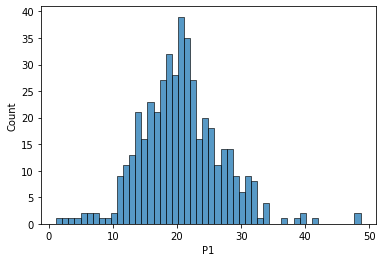

In [174]:
sns.histplot(x = 'P1', data = sofia_grouped, bins = 50)
plt.show()

In [134]:
sofia_dataset[sofia_dataset['P1'] > 100].shape[0]

2769601

In [135]:
sofia_dataset[sofia_dataset['P1'] > 100].shape[0]/sofia_dataset.shape[0]

0.044674755284986475

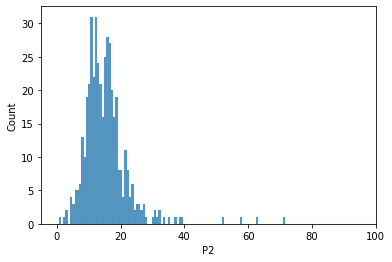

In [130]:
sns.histplot(x = 'P2', data = test_data, bins = 1000)
plt.xlim(-5, 100)
plt.show()

In [143]:
np.nanquantile(sofia_dataset['P2'], 0.975)

80.67

In [131]:
sofia_dataset[sofia_dataset['P2'] > 80].shape[0]

1564279

In [133]:
sofia_dataset[sofia_dataset['P2'] > 80].shape[0]/sofia_dataset.shape[0]

0.025232436557628107

In [144]:
# PM2.5 values
for i in range(sofia_grouped.shape[0]):
    folium.CircleMarker([sofia_grouped["lat"][i], sofia_grouped["lon"][i]], 
                        radius = 4,
                        color = hex_colors[i],
                        fill = True,
                        fill_color =  hex_colors[i], #pressure_flce[i],
                        fill_opacity=1,
                  #popup="<i>sensor {0}</i>".format(sofia_sub["sensor_id"][i]), 
                  tooltip = "<i>PM 2.5 Level : {0} mu g/ ^3<br>sensor : {1}</i>".format(round(sofia_grouped["P2"][i], 2), sofia_grouped["sensor_id"][i])).add_to(m)

In [200]:
# boolean PM2.5 above 50
for i in range(sofia_grouped.shape[0]):
    folium.CircleMarker([sofia_grouped["lat"][i], sofia_grouped["lon"][i]], 
                        radius = 4,
                        color = hex_colors_bool[i],
                        fill = True,
                        fill_color =  hex_colors_bool[i], #pressure_flce[i],
                        fill_opacity=1,
                  #popup="<i>sensor {0}</i>".format(sofia_sub["sensor_id"][i]), 
                  tooltip = "<i>PM 2.5 Level : {0} mu g/ ^3<br>sensor : {1}</i>".format(round(sofia_grouped["P2"][i], 2), sofia_grouped["sensor_id"][i])).add_to(m)

In [95]:
# district colors
for i in range(sensor_latlong.shape[0]):
    folium.CircleMarker([sensor_latlong["lat"][i], sensor_latlong["lon"][i]], 
                        radius = 3,
                        color = dist_colors[test_data['district'][i]],
                        fill = True,
                        fill_color = dist_colors[test_data['district'][i]],
                        fill_opacity=1,
                  #popup="<i>sensor {0}</i>".format(sofia_sub["sensor_id"][i]), 
                  tooltip = "sensor : {0}</i>".format(sensor_latlong["sensor_id"][i])).add_to(m)

In [201]:
m

In [418]:
sensor_latlong

,sensor_id,lat,lon
0,739,42.694000,23.336797
1,753,42.626000,23.378000
2,787,42.708000,23.312000
3,797,42.704895,23.312000
4,1018,42.643000,23.409000
...,...,...,...
448,27059,42.669431,23.233351
449,27209,42.668000,23.386000
450,27957,42.658000,23.374000
451,28130,42.634000,23.374000
